<a href="https://colab.research.google.com/github/pkro/pytorch_for_deep_learning/blob/main/exkurs_micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Follow along to [the video by Andrej Karpathy](https://www.youtube.com/watch?v=VMj-3S1tku0)

The goal is to understand neural networks, backpropagation and gradient descent by using only scalars.

Using Tensors and libraries is just for efficiency reasons, all mathematical operation described here are the same, just over arrays (of arrays of arrays...) of scalars.

"grad": gradient descent

For this, we will be (re-)building [micrograd](https://github.com/karpathy/micrograd). a tiny "autograd" engne with back propagation. More info in the repo's readme.


**Notes from the comments on the video**

>Just and FYI for those following at home. If you are getting an error at 1:54:47 you should add _radd_ into your Value class similar to __rmul__. It will allow the order of addition to not matter. I don't think it was shown in the earlier sections.

>ty, i needed this at t=6422 in order to sum(wi*xi for wi, xi in zip(self.w, x)) + self.b

## Terms

  **Derivative**: The derivative of a function at a particular point is a measure of how the function changes as its input changes. In other words, it's the "instantaneous rate of change" of the function at a specific point. Derivatives are a concept in calculus and apply to functions of a single variable.

  **Gradient**: The gradient is a generalization of the derivative for functions with more than one variable (multivariable functions). If a function has n inputs, its gradient is a vector of n partial derivatives, one for each input. The gradient points in the direction of the steepest ascent - that is, the direction in which the function increases most quickly.

  **Gradient Descent**: Gradient descent is an optimization algorithm that's used to find the minimum of a function. It works by starting at a random point, calculating the gradient of the function at that point, and then taking a step in the direction of the steepest descent (opposite to the gradient). It repeats this process until it reaches a point where the gradient is zero (a minimum).

In [522]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [523]:
# arbitrary function
def f(x):
  return 3 * (x**2) - 4*x + 5

In [524]:
f(3.0)

20.0

[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


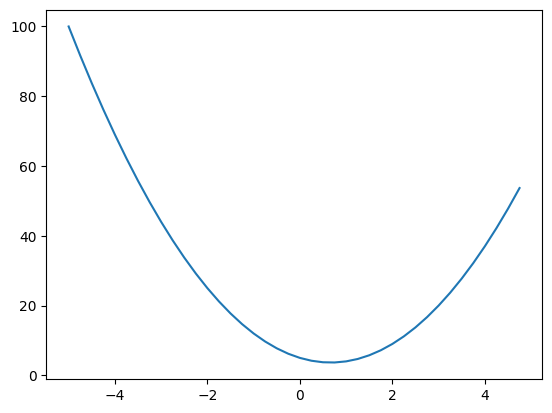

In [525]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
print(ys)
plt.plot(xs, ys)

**What is the derivative (Ableitung / Differentialquotienten) of a function we defined at a different point of x?**

The derivative of a function gives us a measure of how the function changes as its input changes. More specifically, the derivative of a function at a specific point is the slope of the tangent line at that point on the function's graph. It essentially represents the "instantaneous rate of change" of the function at that specific point.

In layman terms: "**What's the direction and steepness of our function if we zoom in as close as possible at a certain point?**"

The derivative of a function **f(x)** at a certain point x can be understood as the limit as h approaches 0 of the difference quotient:

**f'(x) = lim(h -> 0) [f(x + h) - f(x)] / h**

Here, **h** is a very small value, representing a small change in x. The difference quotient **[f(x + h) - f(x)] / h** represents the average rate of change of the function over the interval **h**. As **h** gets smaller and smaller, this average rate of change approaches the instantaneous rate of change, which is the derivative of the function at the point **x**.

By calculating the derivative of a function, we can determine the function's rate of change at any point. This is particularly useful in numerous applications, including physics (to find velocity and acceleration) and machine learning (to find the direction and magnitude of changes in a cost function, for instance in gradient descent).

In [526]:
h = 0.001
x = 3.0

f(x), f(x+h), ( f(x+h) - f(x)) / h # last value is the derivative

(20.0, 20.014003000000002, 14.00300000000243)

In [527]:
# using a smaller h value (at some point we reach the limit of how small h can be for floating point precission)
h = 0.00000001
x = 3.0

( f(x+h) - f(x)) / h

14.00000009255109

**Basically, the slope at x=3 is 14.**

In [528]:
h = 0.00000001
x = -3.0 # slope at -3

( f(x+h) - f(x)) / h

-22.00000039920269

In [529]:
h = 0.00000001
x = 2/3 # slope at x=2/3 is 0 (the lowest point of the curve)

# Again: that means if we add a tiny value to 2/3, the slope stays almost the same (slope = 0)

( f(x+h) - f(x)) / h

0.0

In [530]:
# more complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c #  this is just our specific formula / function for this example

print(d)

4.0


Let's get the derivative of d with respect to a, b and c.

In [531]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

# calculate derivate with respect to a
d1 = a*b + c
a += h # bump a up a bit
d2 = a*b + c

slope = (d2 - d1) / h
d1, d2, slope

(4.0, 3.999699999999999, -3.000000000010772)

> "if you had calculus, you know that differentiating a*b+c with respect to a give you just b"

GPT:

The statement is correct, and it comes from the basic rules of calculus. When you take the derivative of a function, you're essentially finding the rate at which the function's output changes with respect to changes in its inputs.

In your case, the function is f(a) = a*b + c **bold text**. We need to find the derivative of this function with respect to **a**.

When you differentiate a constant times a variable (like a*b **bold text**  in this case, where **b** is considered constant), you simply get the constant. This is because the rate of change of a with respect to **a** is 1, and **b** is just a constant scaling factor, so the derivative is b.

Similarly, when you differentiate a constant (**c** in this case), you get zero. This is because a constant doesn't change, so its rate of change is zero.

So, the derivative of f(a) = a*b + c with respect to a is b*1 + 0 = b **bold text**.

The code you provided calculates this derivative numerically. It finds the change in **f(a)** for a small change in a (that's the **a += h** line, where **h** is a very small number), then divides by the change in **a** to get the rate of change of **f(a)** with respect to **a**, i.e., the derivative.

This numerical approach to calculating derivatives is known as a "*finite difference method*". It's often used in practice when the function is too complex to differentiate symbolically, or when the function is a black box and we can only observe inputs and outputs. However, it is an approximation and can be subject to numerical errors, particularly for very small or very large values of **h**.

In [532]:
# calculate derivate with respect to b
# spoiler: it's a for the same reasons as above

h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h # bump a up a bit
d2 = a*b + c

slope = (d2 - d1) / h
d1, d2, slope

(4.0, 4.0002, 2.0000000000042206)

In [533]:
# calculate derivate with respect to c
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h # bump a up a bit
d2 = a*b + c

slope = (d2 - d1) / h
d1, d2, slope # the slope is 1

(4.0, 4.0001, 0.9999999999976694)

Neural networks are pretty massive mathematical expressions, so we need a data structure that maintains these expressions.

## The actual micrograd Value class is built here

In [534]:
from numpy.lib.function_base import gradient
# goal: maintain the values and the operation on these values that led to the new value

class Value:
    """
    This class encapsulates a node in the computation graph.
    Each node contains a value (data), references to its parent nodes (_prev),
    an operation (_op), and its derivative (grad) which is computed during backpropagation.
    """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data  # The value of this node in the computation.

        # The gradient of the final output with respect to this node.
        # This will be computed during backpropagation.
        self.grad = 0.0

        # _prev contains references to the parent nodes in the computation graph.
        # The parents of a node are the nodes that were used to compute it.
        # Set is used here for efficiency, and to avoid duplicates.
        self._prev = set(_children)

        # _op stores the operation that was used to compute this node.
        # This will be used during backpropagation to compute the gradients.
        self._op = _op

        # The label is just a name for the node, for visualization or debugging purposes.
        self.label = label

        # function for back propagation, default: doesn't do anything (e.g. for leaf nodes)
        self._backward = lambda : None

    def __repr__(self):
        return f"Value(data={self.data}, label=\"{self.label}\")"

    def __add__(self, other):
        """
        Defines the behavior of the '+' operator.
        If 'a' and 'b' are nodes in the computation graph, 'a + b' creates a new node
        which represents the sum of 'a' and 'b'. The new node's parents are 'a' and 'b'.
        """
        # allows to add numbers to Value objects and convert them automatically, e.g. Value(3.0) * 5
        # this does not work for 5 * Value(3.0), for that we need to implement __radd__, __rmul__ etc.
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
          # addition: gradient is always 1.0 (chain rule)
          # "1.0 *" just added for clarity
          #  the gradients from all children need to be added together (according to the multivariate chain rule). This is why we accumulate the gradient using += instead of assigning it with =.;
          #  this also fixes the bug if we use a variable multiple times (e.g. b = a + a)
          #  this goes for all operations
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __sub__(self, other):
      return self + (-other) # for this to work, we need to implement __neg__ (negation)

    def __neg__(self):
      return self * -1

    def __rsub__(self, other):
      return self - other



    # for e.g. 3 + Value(2.0)
    # if python finds this expression, it will check Value if it knows how to handle it with
    # the appropriate __r*__ expression
    def __radd__(self, other):
      return self * other


    def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self, other), '*')

      # chain rule for multiplication:
      def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad

      out._backward = _backward

      return out

    def __rmul__(self, other):
      return self * other

    # division, but more powerful / more general
    # a / b is the same as
    # a * (1/b) is the same as
    # a * (b**-1) is the same as
    def __truediv__(self, other):
      return self * other ** -1


    def __pow__(self, other):
      assert isinstance (other, (int, float)), "only supporting int/float powers for now"
      out  = Value(self.data**other, (self,), f'**(other)')

      def _backward():
        if isinstance(other, Value):  # If other is a Value object
            self.grad += (other.data * (self.data ** (other.data - 1))) * out.grad
            other.grad += (self.data ** other.data * math.log(self.data)) * out.grad
        else:  # If other is an int or float
            self.grad += (other * (self.data ** (other - 1))) * out.grad


      out._backward = _backward

      return out

    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
      out = Value(t, (self, ), 'tanh')

      def _backward():
        # "out.grad is chained through the local gradient into self.grad"
        self.grad += (1 - t ** 2) * out.grad

      out._backward = _backward

      return out


    def exp(self):
      x = self.data
      out = Value(math.exp(x), (self, ), 'exp')

      def _backward():
        self.grad += out.data * out.grad

      out._backward = _backward

      return out





    # this will be called on the last leaf node, the result of the operation chain
    def backward(self):
      topo = []
      visited = set()

      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()




In [535]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f # "final" output of the graph below
L.label = 'L'
L

Value(data=-8.0, label="L")

In [536]:
d._prev # the _children (or rather parents?) of the current value object: the Value generated by a*b and the Value c

{Value(data=-6.0, label="e"), Value(data=10.0, label="c")}

In [537]:
d._op

'+'

In [538]:
# code for visualizing the expression tree / graph

# graph visualization library
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it (not an actual value node / object)
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot




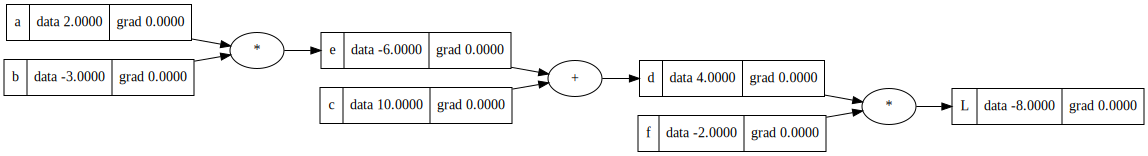

In [539]:
draw_dot(L)

The graph above visualizes the forward pass of the computation, culminating in the final value, **L**.

During the *backpropagation* phase, we start from the final value **L** and compute the derivative (or gradient in multi-dimensional cases) of **L** with respect to every variable in the computation graph (f, d, e, etc.).

This effectively tells us how much a small change in each variable would affect the final output **L**.

For **L** itself, the derivative of **L** with respect to **L** is 1, because they're the same value, and the derivative of a variable with respect to itself is always 1 (if we change **L** by adding 0.1, **L** will be 1.1 so the change derivative is 1).

In the context of neural networks, these variables (f, d, e, etc.) often represent the weights and biases of the network, and the process of backpropagation is used to adjust these parameters to minimize the output of the loss function **L**. In this way, the network 'learns' from the data.

## Manual backpropagation example

In [540]:
# manual backpropagation example

'''
Reminder:

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'

d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f # "final" output of the graph below
L.label = 'L'
L
'''

# The gradient of the final value (L) with respect to itself is always 1.0.
# This is the starting point for backpropagation.
L.grad = 1.0

# First, let's find the derivative of L with respect to d.
# The derivative of a product of two variables with respect to one of them is just the other variable.
# Therefore, the derivative of L with respect to d is f, and we assign this to d.grad.

'''
# L = d * f (the last operation in the graph)

dL / dd = ? # derivative of L with respect to d

(f(x+h)-f(x)) / h
((d+h)* *f* - *d*) / h
(d*f + h*f - d*f) / h
(h*f) / h
f

dL / dd = f

so d.grad is just the value of f and f.grad is the value of d
'''
d.grad = -2.0
# Similarly, the derivative of L with respect to f is d, and we assign this to f.grad.
f.grad = 4.0

'''
Remember, the gradients that you've calculated here (d.grad and f.grad) indicate how much a small change in d and f would affect the final output L. These gradients are used to update the values of d and f in order to minimize L.
'''

"\nRemember, the gradients that you've calculated here (d.grad and f.grad) indicate how much a small change in d and f would affect the final output L. These gradients are used to update the values of d and f in order to minimize L.\n"

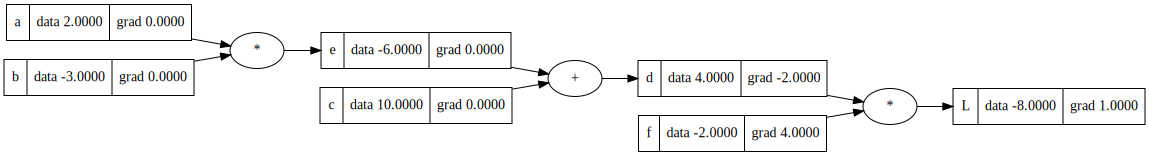

In [541]:
draw_dot(L)

## The most important gradient to understand


In [542]:
# Now we want to calculate dL/dc, which is how L changes with respect to c.

# From the graph we know that L = d * f and d = c + e.
# So, L indirectly depends on c via d. We use the chain rule to find this indirect derivative.

# Chain rule (in Leibniz's notation): If a variable z depends on the variable y, which itself depends on the variable x, then z depends on x as well. The derivative of z with respect to x is the product of the derivative of z with respect to y and the derivative of y with respect to x. Formally: dz/dx = (dz/dy) * (dy/dx).

# Intuitive example:  "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

# In our case, we want to find dL/dc. We know dL/dd from our previous step, and we can find dd/dc as follows:

# dd/dc = 1.0
# Reason: The derivative of d with respect to c is 1 because d = c + e. When we change c by a small amount, d changes by the same amount. Hence, the derivative is 1.

# Now, we have:
# dL/dd = -2.0 (from our previous calculations)
# dd/dc = 1.0 (calculated above)

# According to the chain rule:
# dL/dc = (dL/dd) * (dd/dc) = -2.0 * 1.0 = -2.0

# So, the gradient of L with respect to c is -2.0. We assign this to c.grad.
c.grad = -2.0

# By symmetry, e has the same gradient as c, since d = c + e. So, we also assign e.grad = -2.0.
e.grad = -2.0

# dL / dc
# How do we derive dL by dc?


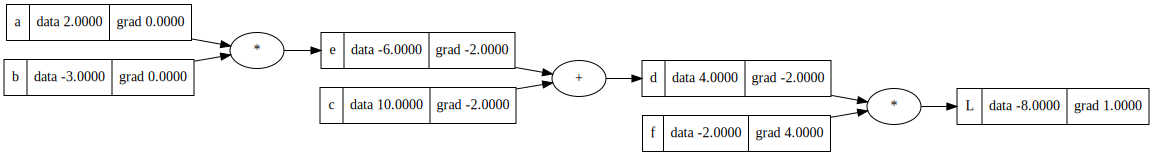

In [543]:
draw_dot(L)

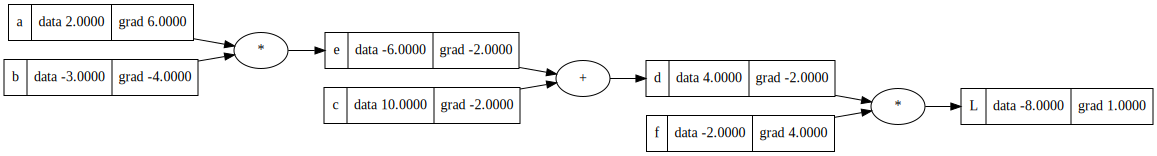

In [544]:
# next application of chain rule (multiplication), going backwards through the graph

# dL / de = -2.0
# e = a * b
# de / da ? -> b
# dL / da = (dL / de) * (de / da)
a.grad = (-2.0 * -3.0)
b.grad = -2.0 * 2.0

draw_dot(L)

In [545]:
# Gradient Descent Update

# Having computed the gradients of the final value `L` with respect to the inputs `a`, `b`, `c`, and `f`,
# we can now perform a gradient descent step to adjust these inputs in a way that will minimize `L`.

# This is done by subtracting a small fraction (0.01 in this case, also known as the learning rate)
# of the gradients from the current values. The gradient indicates the direction of steepest increase,
# so subtracting it moves us towards the direction of steepest decrease, i.e., towards the minimum.

a.data -= 0.01 * a.grad
b.data -= 0.01 * b.grad
c.data -= 0.01 * c.grad
f.data -= 0.01 * f.grad

# We then recompute `e`, `d`, and `L` with the updated values.
e = a * b
d = e + c
L = d * f

# The value of `L` should decrease with each iteration of this process, showing that our optimization is working.
L.data

-8.726303999999999

In [546]:
# gating function so we don't change the global variables

# used to quickly verify back propagation / gradient check

def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  a.data += h
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')

  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()



6.000000000000227


## More complicated example

Mathematical model of neuron / neuronal network:

```
  Inputs             Hidden Layer           Output Layer
X1 ----\             /---\                /---\
        (W1) ----->  |   | + B1           |   | + B2
X2 ----/             \---/                \---/
                       Neuron1
```

- X1 and X2 are the inputs to the neural network. They could be anything: pixels in an image, words in a text, etc.

- W1 is the weight associated with the connection between the input and the neuron in the hidden layer. Weights essentially determine the influence of an input on a neuron's output. A larger weight means the input has a bigger influence.

- B1 is the bias term associated with Neuron1. It's a trainable parameter that provides an extra degree of freedom to the model. The bias helps adjust the output of the neuron along with the weighted sum of the inputs.

- Neuron1 is a single neuron in the hidden layer. It receives input from X1 and X2, multiplies these inputs by their respective weights (in this case W1), adds the bias B1, and then applies an activation function to this sum (like the tanh function you learned about). The result is then passed onto the next layer.

- The output layer consists of another neuron that takes the output from Neuron1 (and potentially others if the network is more complex), applies another set of weights, adds a bias B2, and gives the final output of the neural network.

Including bias in your neural network can help to improve the accuracy of your model. It allows the activation function to shift to the left or the right, which may help the neuron better fit the data.

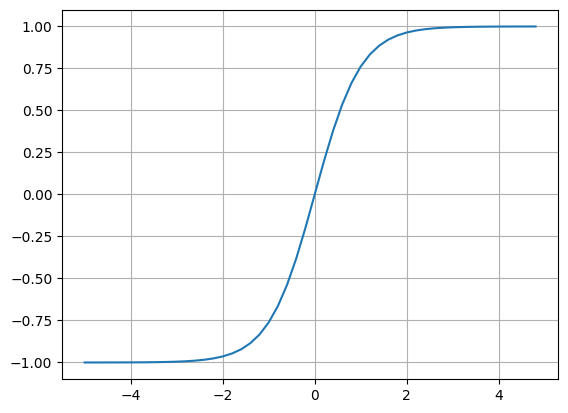

In [547]:
# activation / cap / squashing function
# cappint to 1 / -1
plt.plot(np.arange(-5,5, 0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Explanation of above graph:

The graph is for a function known as the hyperbolic tangent function, commonly written as tanh. The tanh function is frequently used in machine learning and specifically in neural networks as an activation function. Here's why:

- The tanh function squashes its input to be between -1 and 1. That is, no matter how large or small your input is, the output will always be within the range [-1, 1]. This is beneficial in neural networks as it helps to keep the activations and hence the learning under control. It is often used in the hidden layers of a neural network.

- The tanh function is zero-centered, meaning it outputs values that are negative, zero, and positive, making it easier for the subsequent layers to learn from the activated outputs of previous layers.

- The tanh function has relatively steep gradients for inputs near 0, which means the neural network can learn rapidly for these inputs. For very large positive or negative inputs, the function saturates at +1 or -1, meaning the gradient is close to zero and learning is slow (known as the vanishing gradients problem).

The plot you've generated shows these properties visually: The x-axis represents the input to the tanh function and the y-axis represents the output. As you can see, for large positive and negative inputs, the output approaches 1 and -1 respectively. Around 0, the output varies rapidly.

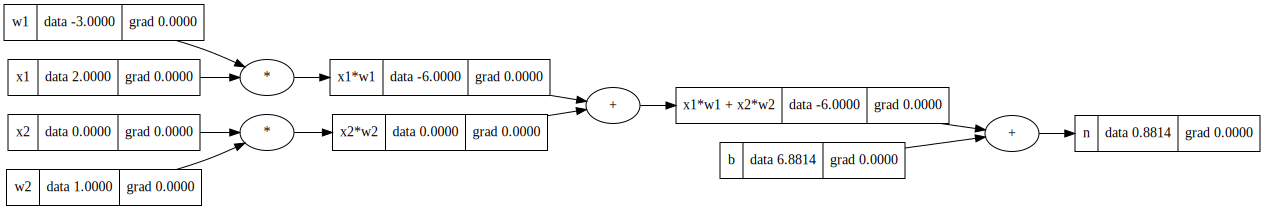

In [548]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# Compute weighted sums for each input
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

# Compute total input into neuron by adding weighted sums and bias
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1*w1 + x2*w2'

n = x1w1_plus_x2w2 + b; n.label = 'n'

# n is the raw value of the neuron before applying the activation function (squashing)

draw_dot(n)


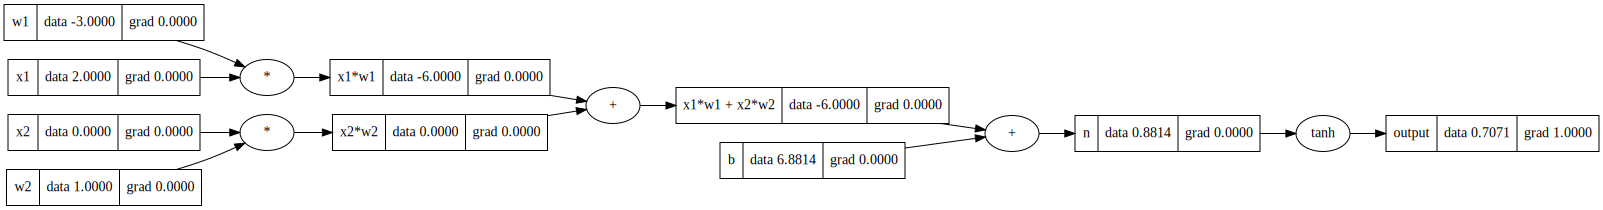

In [549]:
#calculate output with activation function (tanh)
o = n.tanh(); o.label='output'; o.grad = 1.0
draw_dot(o)

In [550]:
# calculate local derivative at the tanh node
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2

local_derivative_tanh = 1-o.data**2 # 0.4999999999999999
print(local_derivative_tanh)
# Set the gradient at the neuron output equal to the local derivative
n.grad = 0.5
print(n.grad)

0.4999999999999999
0.5


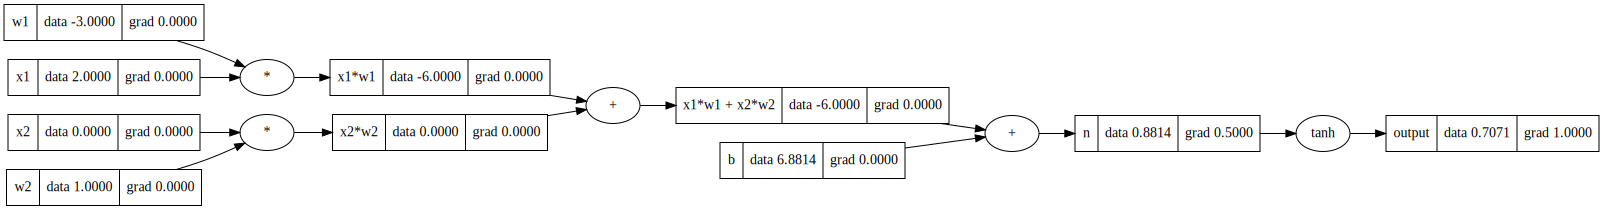

In [551]:
draw_dot(o)

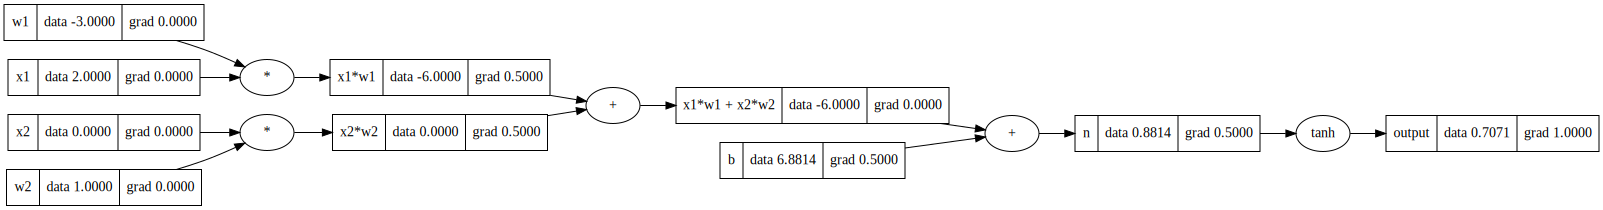

In [552]:
# continue backpropagation
# local derivative of + node is just 1.0
# A plus node simply distributes the gradient, so the gradient at 'n' will flow into its parents equally
x1w1_plus_x2w2 = 0.5
# The gradient of the bias term is the same as the gradient at the neuron output (due to the addition operation)
b.grad = 0.5

# again just a plus node
x1w1.grad = 0.5
x2w2.grad = 0.5

draw_dot(o)

Reminder: what is the backpropagation telling us so far?

All nodes so far have positive contributions to the output (grad > 0), meaning that an increase of the input means an increase of the output.

It's important to remember that these gradients provide linear approximations to the sensitivity of the output with respect to the inputs and parameters. They are most accurate for small changes in the input and less so for larger changes.

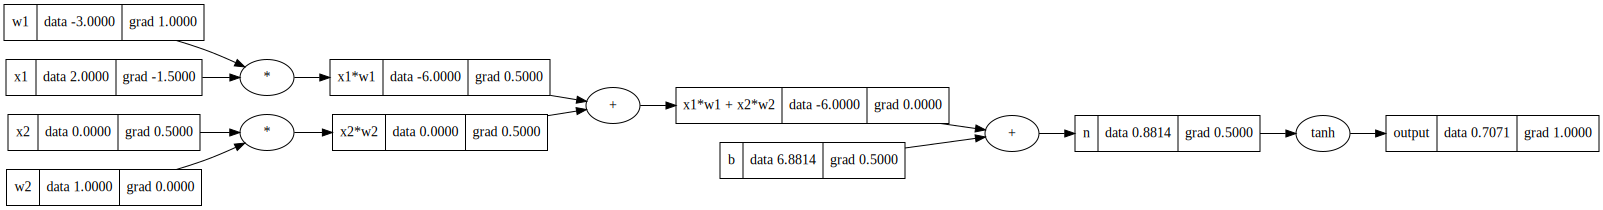

In [553]:
# Continue backpropagation (final derivatives)

# For multiplication nodes, the gradient is the other input times the gradient of the output.

# Gradients for x1 and w1:
x1.grad = w1.data * x1w1.grad  # The gradient of x1 is the value of w1 times the gradient from the next node.
w1.grad = x1.data * x1w1.grad  # The gradient of w1 is the value of x1 times the gradient from the next node.
# Note: Since w1 is negative and the output gradient is positive, an increase in w1 (towards 0) would increase the output.

# Gradients for x2 and w2:
x2.grad = w2.data * x2w2.grad  # The gradient of x2 is the value of w2 times the gradient from the next node.
w2.grad = x2.data * x2w2.grad  # The gradient of w2 is the value of x2 times the gradient from the next node.
# Note: Since x2 is zero, its gradient and the gradient of w2 (which is multiplied by x2) both are 0.
# This means changes in x2 and w2 will have no effect on the output.


draw_dot(o)


## After adding the backward funcitonality to the value class

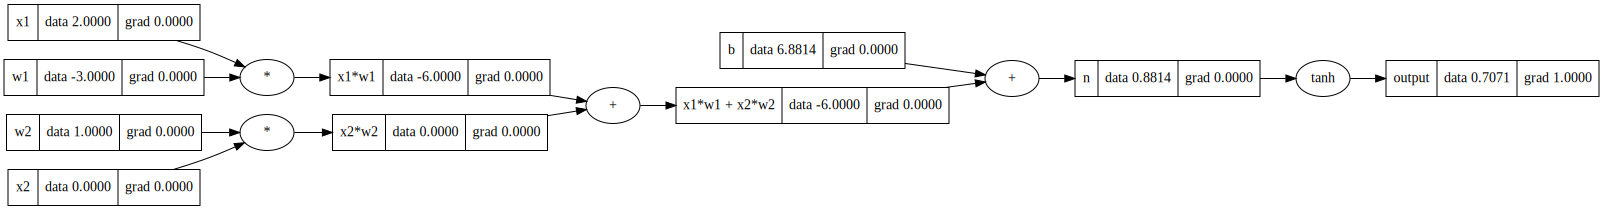

In [554]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# Compute weighted sums for each input
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

# Compute total input into neuron by adding weighted sums and bias
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1*w1 + x2*w2'

n = x1w1_plus_x2w2 + b; n.label = 'n'

# n is the raw value of the neuron before applying the activation function (squashing)

o = n.tanh(); o.label='output'; o.grad = 1.0

draw_dot(o)

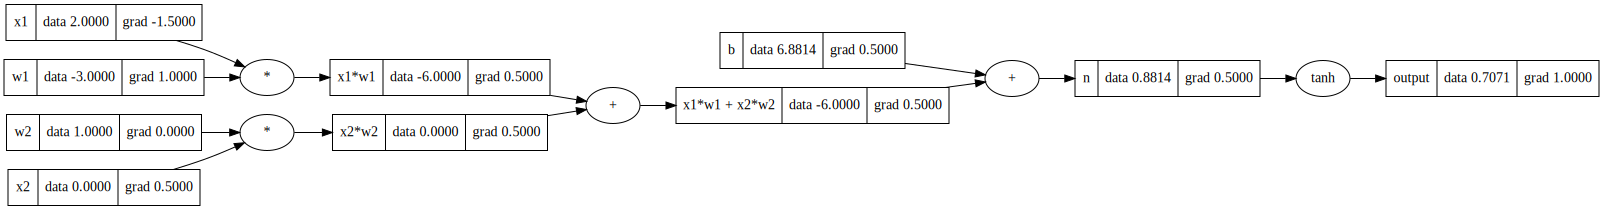

In [555]:
o._backward()
n._backward()
# b._backward() # b is a leaf node so it doesn't have a backward (that does anything)
x1w1_plus_x2w2._backward()
x2w2._backward()
x1w1._backward()
draw_dot(o)

## Automating

We don't want to call _backward() on any node until we have done anything after it.

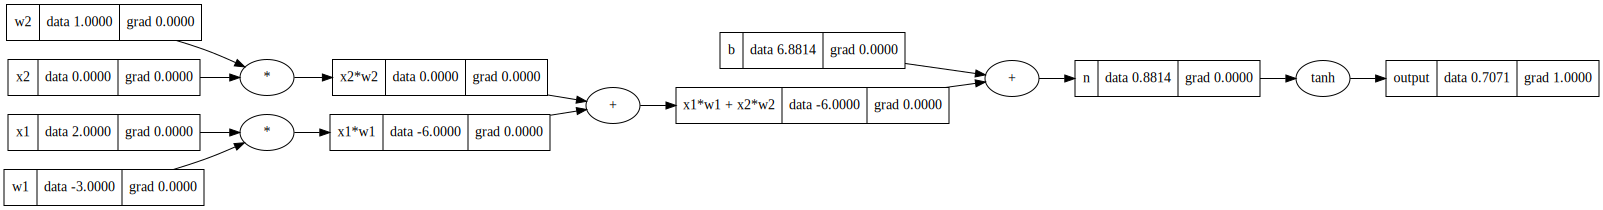

In [556]:
# just resetting everything

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# Compute weighted sums for each input
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

# Compute total input into neuron by adding weighted sums and bias
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1*w1 + x2*w2'

n = x1w1_plus_x2w2 + b; n.label = 'n'

# n is the raw value of the neuron before applying the activation function (squashing)

o = n.tanh(); o.label='output'; o.grad = 1.0

draw_dot(o)

### Topoligical sort / ordering of graph

> a topological sort is a graph traversal in which each node v is visited only after all its dependencies are visited.

[Source](https://en.wikipedia.org/wiki/Topological_sorting)

In [557]:
# implementation of topological sort (for our Value objects)
# (before we put it into the Value class)
topo = []
visited = set()

def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)


build_topo(o)

topo # is now ordered so the last value is the output o

[Value(data=1.0, label="w2"),
 Value(data=0.0, label="x2"),
 Value(data=0.0, label="x2*w2"),
 Value(data=2.0, label="x1"),
 Value(data=-3.0, label="w1"),
 Value(data=-6.0, label="x1*w1"),
 Value(data=-6.0, label="x1*w1 + x2*w2"),
 Value(data=6.881373587019543, label="b"),
 Value(data=0.8813735870195432, label="n"),
 Value(data=0.7071067811865476, label="output")]

Now we just have to call all _backward() on all nodes in the topological order (back to front)

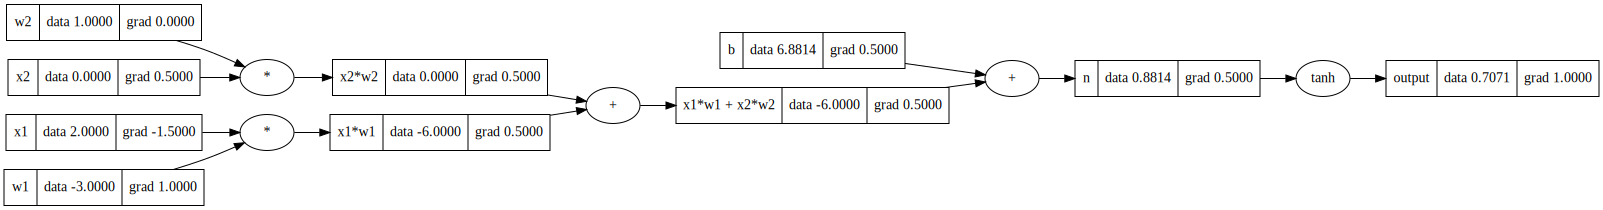

In [558]:
o.grad = 1.0

for node in reversed(topo):
  node._backward()

draw_dot(o)

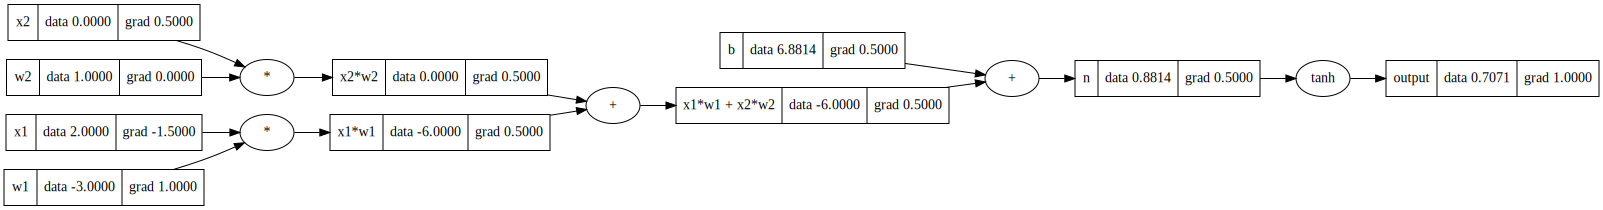

In [559]:
# After moving the backward / topo functionality into the Value class:

# just resetting everything

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# Compute weighted sums for each input
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

# Compute total input into neuron by adding weighted sums and bias
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1*w1 + x2*w2'

n = x1w1_plus_x2w2 + b; n.label = 'n'

# n is the raw value of the neuron before applying the activation function (squashing)

o = n.tanh(); o.label='output'; o.grad = 1.0

o.backward()
draw_dot(o)

## Some debugging

There is a problem if we use a variable more than once because gradients can get overridden

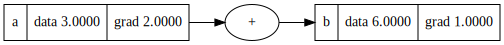

In [560]:
# debugging
a = Value(3.0, label='a')
# as both child nodes are the same object _backward will set them both to the same value
b = a + a; b.label ='b'
b.grad = 1.0
b.backward()
draw_dot(b)
# in the graph, there are actually 2 arrows on top of each otherb

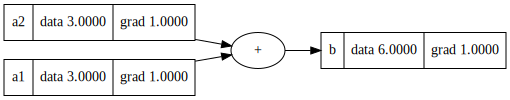

In [561]:
# same example with different objects (but they are still both 1.0, so no problem with plus nodes?)
a1 = Value(3.0, label='a1')
a2 = Value(3.0, label='a2')
b = a1 + a2; b.label ='b'
b.grad = 1.0
b.backward()
draw_dot(b)

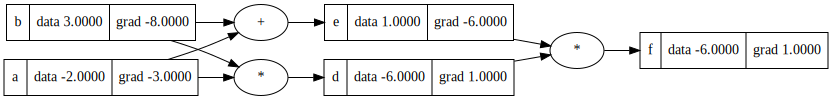

In [562]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

### Result debugging:

We must *add* to the gradients in the _backward functions in the Value class using "+=" instead of just re-defining them ("=")


## Continuing from part "breaking up tanj, exercising with more operations" (1:27)

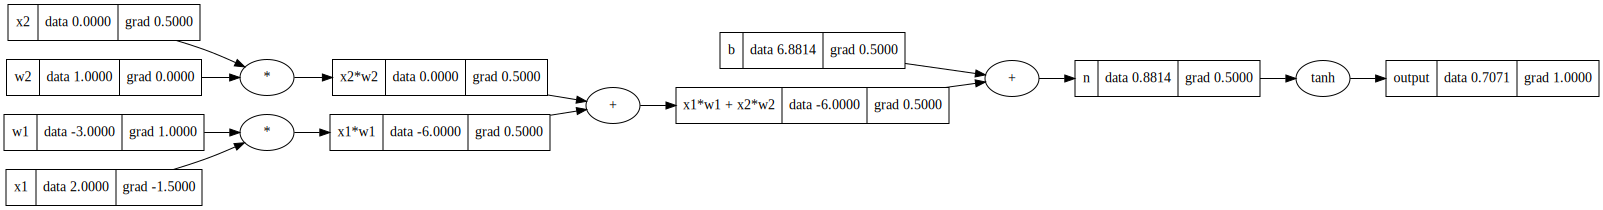

In [563]:
# same as before

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# Compute weighted sums for each input
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

# Compute total input into neuron by adding weighted sums and bias
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1*w1 + x2*w2'

n = x1w1_plus_x2w2 + b; n.label = 'n'

# n is the raw value of the neuron before applying the activation function (squashing)

o = n.tanh(); o.label='output'; o.grad = 1.0

o.backward()
draw_dot(o)

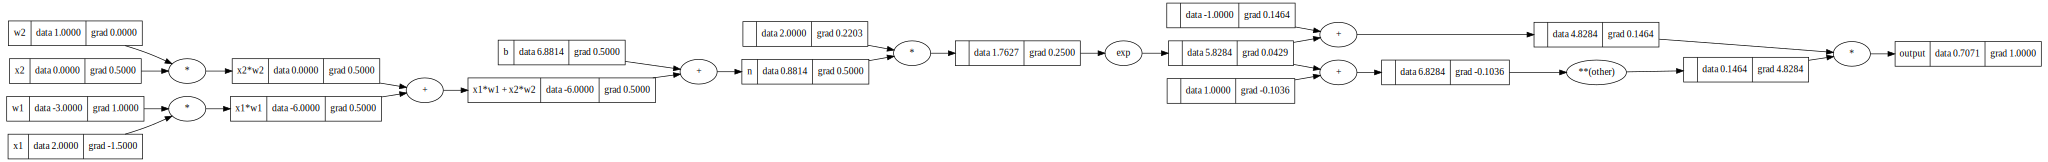

In [564]:
# using the new expressions we defined in Value class for tanh

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# Compute weighted sums for each input
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

# Compute total input into neuron by adding weighted sums and bias
x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1*w1 + x2*w2'

n = x1w1_plus_x2w2 + b; n.label = 'n'

# n is the raw value of the neuron before applying the activation function (squashing)

# ------- changed ---------

#o = n.tanh()
e = (2*n).exp()
o = (e-1) / (e+1)

o.label='output'; o.grad = 1.0

# ------- /changed ---------
# no worky, check class
o.backward()
draw_dot(o)

In [565]:
a = Value(2.0)
(1+a).exp().grad

0.0

# Doing back-propagation in pytorch

In [566]:
import torch

# in pytorch, everything is a tensor and not scalars as in our previous code
# we cast it to double / float64 (default is float32)
x1 = torch.Tensor([2.0]).double();
# tell pytorch that gradients are required for the nodes (default is False)
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b=torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [567]:
# just showing what item() does
o, o.item(), x2.grad, x2.grad.item()

(tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>),
 0.7071066904050358,
 tensor([0.5000], dtype=torch.float64),
 0.5000001283844369)

In [568]:
class Neuron:
  # nin = number of inputs
  def __init__(self, nin):
    # create a random weight for each input
    self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
    # bias ("trigger happiness")
    self.b = Value(np.random.uniform(-1,1))

  def __call__(self, x):
    '''function that gets executed when an object of the class is called using ()'''
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b) + self.b
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # simplified
    return [p for neuron in self.neurons for p in neuron.parameters()]
    '''params = []
    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps) # append appends 1 element, extend adds (concatenates) a list of values to a list
    return params'''

# multi layer perceptron
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts;
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1]) # 3 inputs, 2 hidden layers with 4 neurons, 1 output value
n(x)

Value(data=-0.96998922456021, label="")

In [569]:
# example dataset
# 4 input examples
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# desired targets (true values / labels for the 4 inputs above)
ys = [1.0, -1.0, -1.0, 1.0]

# forward pass
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.96998922456021, label=""),
 Value(data=-0.9769789356933636, label=""),
 Value(data=-0.9796858478558754, label=""),
 Value(data=-0.9795100196638271, label="")]

In [570]:
# measure total performance with loss
# subtract ground truth values (from ys) from predictions and square result
# the result is squared to always have positive numbers, we could use abs, too
# but i think squaring has an additional effect
# the smaller (0 = zero loss) the resulting number, the better the prediction
squared_errors = [(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]
squared_errors

[Value(data=3.8808575448833373, label=""),
 Value(data=0.0005299694018102893, label=""),
 Value(data=0.0004126647773346411, label=""),
 Value(data=3.9184599179494852, label="")]

In [571]:
# loss is actually a single number
loss = sum(squared_errors)
loss

Value(data=3.91940255212863, label="")

In [572]:
loss.backward()

In [573]:
# we now have the grad / influence of the individual weights
n.layers[0].neurons[0].w[0], n.layers[0].neurons[0].w[0].grad

(Value(data=-0.5220848033473342, label=""), 0.029484815243676233)

In [574]:
# in gradient descent, we are thinking of the gradient descent as a vector pointing in the direction of increased loss
for p in n.parameters():
  # change the weights by a tiny amount (step size) times the gradient
  # if the weight's grad is negative, the weight gets smaller, otherwise larger
  # if the gradient of the neuron is negative,
  p.data += -0.01 * p.grad

In [575]:
# weight is now slightly lower (since we had a positive gradient, otherwise it would go up)
n.layers[0].neurons[0].w[0], n.layers[0].neurons[0].w[0].grad

(Value(data=-0.522379651499771, label=""), 0.029484815243676233)

In [576]:
def recalculate_loss():
  # forward pass
  ypred = [n(x) for x in xs]
  # calculate loss
  squared_errors = [(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]
  loss = sum(squared_errors)
  return loss
#loss is now slightly lower, great
recalculate_loss()


Value(data=3.9170702443419394, label="")

In [577]:
# and lower...
# COMMON MISTAKE: Not zero_grad (reset) the gradients before doing the backward pass
for p in n.parameters():
  p.grad = 0.0
loss.backward()
for p in n.parameters():
  p.data += -0.01 * p.grad

recalculate_loss()

Value(data=3.890969982750603, label="")

In [578]:
# and lower (or it goes up again if we stepped over the local minimum)
# COMMON MISTAKE: Not zero_grad (reset) the gradients before doing the backward pass
for p in n.parameters():
  p.grad = 0.0
loss.backward()
for p in n.parameters():
  p.data += -0.01 * p.grad

recalculate_loss()


Value(data=3.474831558221687, label="")

So, in summary, gradient descent is:

1. **Forward Pass**: This is the process where the input is passed through the network layer by layer, applying weights, biases, and activation functions until you get the final output. It's essentially the computation of the neural network's prediction for a given input.

2. **Calculating the Loss**: After the forward pass, you have the predicted output of the network. The loss (or cost) function then measures the difference between this predicted output and the actual target values. The result of this function gives you a single value representing the "error" or "loss" of the network's prediction for that specific input. There are several possible ways to calculate loss, we use the sum of the squared error (SSE) here. MSE (Mean squared errors) would divide the sum by the number of the number of values.

3. **Backward pass / backpropagation**: This is the process where the computed loss is propagated backward through the network. Starting from the output layer and moving toward the input layer, the gradients of the loss with respect to the weights and biases are computed. This is done using the chain rule of differentiation. The main goal of backpropagation is to find out how much each weight and bias in the network contributed to the error, and in which direction they need to be adjusted to reduce the error.

4. **Update**: After backpropagation provides the gradients (i.e., the direction and magnitude to adjust), the weights and biases in the network are updated using these gradients. Typically, an optimization algorithm like Stochastic Gradient Descent (SGD) or one of its variants (like Adam or RMSprop) is used to perform this update. The weights are adjusted in the direction that minimizes the loss. This step is repeated iteratively, adjusting the weights and biases little by little, until the loss converges to a minimum value.

5. **repeat from 1.**

## Create a training loop


In [583]:
# re-initialize everything
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# desired targets (true values / labels for the 4 inputs above)
ys = [1.0, -1.0, -1.0, 1.0]

In [584]:
n = MLP(3, [4,4,1]) # 3 inputs, 2 hidden layers with 4 neurons, 1 output value

In [585]:
# 20 steps with a learning rate of 0.05
steps = 20
learning_rate = 0.05
for k in range(steps):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  # COMMON MISTAKE: Not zero_grad (reset) the gradients before doing the backward pass
  # otherwise the backward pass changes the numbers based on the numbers from the previous pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -learning_rate * p.grad

  print(k, loss.data)


0 1.8474068605694554
1 1.0338380790875625
2 0.7327502647142841
3 0.27422931778697046
4 0.16843573459703745
5 0.13680997971270567
6 0.11482338275440271
7 0.0985564433785046
8 0.08608144337847184
9 0.07624216366938061
10 0.06830291127238149
11 0.061774770272802836
12 0.05632104317876678
13 0.051702814402276545
14 0.04774616945751979
15 0.04432169049785378
16 0.04133120470199668
17 0.038698973021453566
18 0.036365683270058506
19 0.03428426349500044


In [586]:
ypred # the closer to [1.0, -1.0, -1.0, 1.0] (our known labels), the better

[Value(data=0.9183918363285751, label=""),
 Value(data=-0.9550481995909915, label=""),
 Value(data=-0.8804522580744686, label=""),
 Value(data=0.8659405485036745, label="")]